In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
energies_post_frad_log = '/home/nobilm@usi.ch/pretrain_paper/energies_post_frad_log.txt'
rdkit_energies_not_minimized_log = '/home/nobilm@usi.ch/pretrain_paper/rdkit_energies_not_minimized_log.txt'
rdkit_energies_minimized_log = '/home/nobilm@usi.ch/pretrain_paper/rdkit_energies_minimized_log.txt'

In [13]:
df1 = pd.read_csv(rdkit_energies_not_minimized_log, header=None, names=['value'])
pd.options.display.float_format = '{:.6f}'.format
df1.describe()

,value
count,231.000000
mean,172.760172
std,220.842568
min,-130.997389
25%,61.660095
50%,105.349078
75%,227.071797
max,1735.969243


In [14]:
df2 = pd.read_csv(rdkit_energies_minimized_log, header=None, names=['value'])
pd.options.display.float_format = '{:.6f}'.format
df2.describe()

,value
count,231.000000
mean,58.390054
std,101.394976
min,-294.884296
25%,17.337176
50%,53.868467
75%,96.940921
max,781.937709


In [15]:
df3 = pd.read_csv(energies_post_frad_log, header=None, names=['value'])
pd.options.display.float_format = '{:.6f}'.format
df3.describe()

,value
count,231.000000
mean,2594.894483
std,27479.935427
min,-293.791004
25%,27.145629
50%,63.816559
75%,115.258420
max,404904.977620


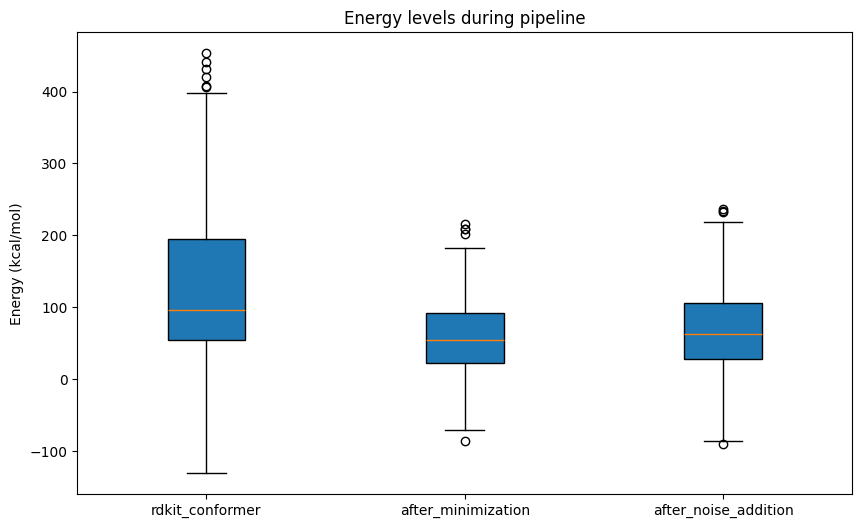

In [19]:
def remove_outliers(df):
    Q1 = df['value'].quantile(0.25)
    Q3 = df['value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df['value'] >= lower_bound) & (df['value'] <= upper_bound)]



dfs = [remove_outliers(df1), remove_outliers(df2), remove_outliers(df3)]
# Plot the boxplots
plt.figure(figsize=(10, 6))  # Set the figure size
plt.boxplot([df['value'] for df in dfs], patch_artist=True)  # Create boxplots

# Set plot labels and title
plt.xticks([1, 2, 3], ['rdkit_conformer', 'after_minimization', 'after_noise_addition'])  # Set x-axis labels
plt.ylabel('Energy (kcal/mol)')
plt.title('Energy levels during pipeline')

# Show the plot
plt.show()


In [1]:
from my_general_utils import get_field_from_npzs
l = get_field_from_npzs('/storage_common/nobilm/pretrain_paper/opioid/single_smiles')
len(l)

2

In [11]:
sum(l[i]['graph_labels'] for i in range(len(l))), len(l)-sum(l[i]['graph_labels'] for i in range(len(l)))

(array([[11.]], dtype=float32), array([[220.]], dtype=float32))

In [2]:
l[0]

NpzFile '/storage_common/nobilm/pretrain_paper/opioid/single_smiles/fentanil_minimized.npz' with keys: coords, atom_types, graph_labels, hybridization, chirality...

# test new pipeline for conforme generator and energy evaluation

In [1]:
# !pip install cdpkit
# 1 load mols from npzs
# 2 create 2 copies of them
# 3 on 1 apply rdkit minimization, and then get final energies
# 4 on the other apply new method, and then get final energies
# 5 compare via code above



# 1 load mols from npzs
from my_general_utils import get_field_from_npzs, get_conformer, visualize_3d_mols, preprocess_mol
from source.data_transforms._frad_transforms import get_energy, minimize_energy
from rdkit import Chem as rdChem
from conforge import *

def f(m):
  m = preprocess_mol(m)
  if get_conformer(m) == None: raise ValueError("Mol bad conformer Id")
  print('Energy pre minimization: ' , get_energy(m))
  m, en = minimize_energy(m)
  print('Energy post minimization: ' , en)
  return m

og_smiles = get_field_from_npzs('/storage_common/nobilm/pretrain_paper/opioid/single_smiles', field='smiles')

In [2]:
sdf_file_path = './new_conformers.sdf'
generate_conf_sdf(og_smiles, sdf_file_path)

# The forcefield is not going to behave properly if you remove Hs.
# Please try setting the SDMolSupplier to not remove Hs and then try your minimization.
new_mols = rdChem.SDMolSupplier(sdf_file_path, removeHs=False)
new_mol1, new_mol2 = new_mols

Start writing ./new_conformers.sdf


100%|██████████| 2/2 [00:00<00:00, 98.43it/s]

Write ended ok


In [3]:
rdkit_mols = [rdChem.MolFromSmiles(smi) for smi in og_smiles]
rdkit_m1, rdkit_m2 = rdkit_mols

In [4]:
print('With rdkit conformer generator')
rdkit_m1 = f(rdkit_m1)
print('\n')
print('Wtih new conformer generator')
f(new_mol1);

With rdkit conformer generator
Energy pre minimization:  327.75048900263084
Energy post minimization:  59.559990654321936


Wtih new conformer generator
Energy pre minimization:  59.17871173835183
Energy post minimization:  53.07712007350229


In [5]:
print('With rdkit conformer generator')
rdkit_m2 = f(rdkit_m2)
print('\n')
print('Wtih new conformer generator')
f(new_mol2);

With rdkit conformer generator


Energy pre minimization:  234.547827885911
Energy post minimization:  101.94182906708438


Wtih new conformer generator
Energy pre minimization:  97.46525358605433
Energy post minimization:  89.16362684586609


In [6]:
print('With rdkit conformer generator')
visualize_3d_mols([rdkit_m1, rdkit_m2])

With rdkit conformer generator


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [7]:
print('Wtih new conformer generator')
visualize_3d_mols(list(new_mols))

Wtih new conformer generator


3Dmol.js failed to load for some reason. Please check your browser console for error messages.